 # QLBS model for European Options
 
Part 1 of the notebook will hedge then price an option with a recursive dynamic programming solution (DP), an on-policy with risk aversion parameter.

Part 2 of the notebook will hedge then price an option with the same DP solution but with transaction costs added to the hedging process.

Part 3 will be on Fitted Q-Iteration (FQI) in a model-free, off policy setup to learn the optimal price and hedge directly from MC or historical data.

## Part 1: QLBS DP approach (Known price-dynamics)
- Monte Carlo (MC) simulation of stock paths
- Computation of optimal hedge $a_t^\star(X_t)$ with minimum variance technique
- Backward recursively update and determine the optimal Q-function $Q_t^\star(X_t, a_t^\star)$ in basis functions with time-dependend coefficients


In [70]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import os

In [71]:
# User Inputs
# GLOBAL VARIABLES THAT DEFINE THE MODEL

## market dynamics
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.04      # risk-free rate

## option details
opt_type = 'Put'
M = 1         # maturity
K = 100       # option stike 
T = 4        # number of time steps
N_MC = 4  # number of paths

## market dynamics
delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

np.random.seed(42)

## Monte Carlo Simulation

## Initialization

In [72]:
def gen_stock_paths(S0, mu, sigma, T, N_MC, delta_t, r):
    """
    Simulates stock prices using Geometric Brownian Motion, computes adjusted stock returns,
    and calculates the log-processed state variable.

    Parameters:
    - S0: Initial stock price.
    - mu: Expected return.
    - sigma: Volatility of the stock.
    - T: Total time period.
    - N_MC: Number of Monte Carlo simulations.
    - delta_t: Time increment.
    - r: Risk-free interest rate.

    Returns:
    - S: DataFrame of simulated stock prices.
    - delta_S: DataFrame of stock returns.
    - delta_S_hat: DataFrame of adjusted stock returns.
    - X: DataFrame of log-processed state variables for each time step.
    - execution_time: Time taken to execute the simulation.
    """
    starttime = time.time()

    # Initialize empty DataFrame for stock prices
    S = pd.DataFrame([], index=range(1, N_MC + 1), columns=range(T + 1), dtype=float)
    S.loc[:, 0] = S0  # Set initial stock price for each simulation

    # Generate standard normal random variables
    RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC + 1), columns=range(1, T + 1))

    # Simulate stock price paths with Geometric Brownian Motion
    for t in range(1, T + 1):
        S.loc[:, t] = S.loc[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])

    # Calculate stock returns at each step
    delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]

    # Adjust stock returns by subtracting the mean return at each time step
    delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

    # Define the log-processed state variable for each time step
    X = - (mu - 0.5 * sigma**2) * np.tile(np.arange(T + 1) * delta_t, (N_MC, 1)) + np.log(S)

    endtime = time.time()
    execution_time = endtime - starttime

    print('\nExecution Time:', execution_time, 'seconds')

    return S, delta_S, delta_S_hat, X


In [73]:
# GLOBAL VARIABLES THAT DEFINE THE MODEL

S, delta_S, delta_S_hat, X = gen_stock_paths(S0, mu, sigma, T, N_MC, delta_t, r)


Execution Time: 0.006915092468261719 seconds


In [74]:
S

,0,1,2,3,4
1,100.0,104.806024,104.734536,111.018079,125.663513
2,100.0,99.215692,98.437656,111.893986,119.677063
3,100.0,97.479988,102.516792,99.978762,97.486660
4,100.0,102.822567,89.944817,79.799321,77.248766


In [75]:
delta_S

,0,1,2,3
1,3.801007,-1.124805,5.230943,13.529684
2,-1.789325,-1.775170,12.467016,6.658524
3,-3.525029,4.057114,-3.568341,-3.496905
4,1.817551,-13.911134,-11.049456,-3.352552


In [76]:
delta_S_hat

,0,1,2,3
1,3.724956,2.063694,4.460903,10.194996
2,-1.865376,1.413329,11.696975,3.323836
3,-3.601080,7.245613,-4.338381,-6.831592
4,1.741500,-10.722635,-11.819497,-6.687240


### Payoff function

Define function *terminal_payoff* to compute the terminal payoff of a European option

Call: $$H_T\left(S_T\right)=\max\left(S_T-K,0\right)$$

Put: $$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [77]:
def terminal_payoff(ST, K, option_type):
    """
    Calculates the terminal payoff for call and put options.

    Parameters:
    - ST: Final stock price.
    - K: Strike price.
    - option_type: Type of the option ('call' or 'put').

    Returns:
    - The terminal payoff of the option.
    """
    if option_type.lower() == 'call':
        payoff = max(ST - K, 0)
    elif option_type.lower() == 'put':
        payoff = max(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return payoff

### Black-Scholes Formula

In [78]:
def bs_price(t, S0=S0, K=K, r=r, sigma=sigma, T=M, option_type=opt_type):
    """
    Calculates the Black-Scholes price for call and put options.

    Parameters:
    - option_type: Type of the option ('call' or 'put').
    - t: Current time.
    - S0: Initial stock price.
    - K: Strike price.
    - r: Risk-free interest rate.
    - sigma: Volatility of the underlying asset.
    - T: Time to maturity.

    Returns:
    - The Black-Scholes price of the option.
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)

    if option_type.lower() == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * (T - t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

##  Define spline basis functions  

Interpolate discretized problems to solve PDE using bspline to approximate the functions 

In [79]:
import bspline
import bspline.splinelab as splinelab


def gen_bspline_basis(X, p=4, ncolloc=12):
    """
    Generates a set of B-spline basis functions.

    Parameters:
    - X: State space DF used to define the range of the spline.
    - p: Order of the spline.
    - ncolloc: Number of collocation points/B-spline functions
    """
    X_min = np.min(X)
    X_max = np.max(X)
    print('X.shape = ', X.shape)
    print('X_min, X_max = ', X_min, X_max)

    tau = np.linspace(X_min, X_max, ncolloc)  # Interpolation sites

    # Generate the knot vector and create the spline basis
    k = splinelab.aptknt(tau, p)
    basis = bspline.Bspline(k, p)

    print('Number of points k = ', len(k))

    # Plotting
    f = plt.figure()
    basis.plot()

    # Ensure the save directory exists
    save_dir='basis_func_plots'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save the figure with a filename that includes the number of basis functions
    filename = f'{save_dir}/Basis_functions_{ncolloc}.png'
    plt.savefig(filename, dpi=600)
    print(f'Plot saved to {filename}')

    # Optionally, close the plot if not needed to be shown interactively
    plt.close(f)
    
    return basis

X.shape =  (4, 5)
X_min, X_max =  4.3082809358746585 4.794857804464249
Number of points k =  6


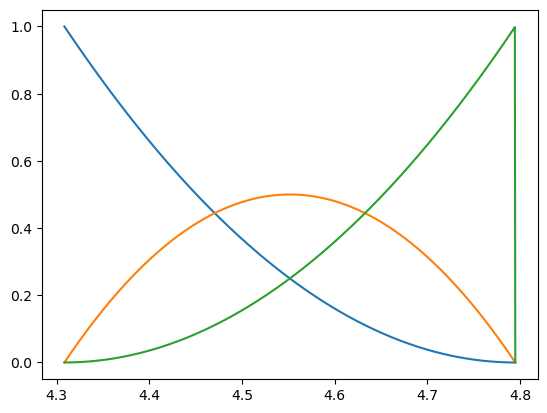

Plot saved to basis_func_plots/Basis_functions_3.png


<Figure size 640x480 with 0 Axes>

In [80]:
basis = gen_bspline_basis(X, p=2, ncolloc=3)

In [81]:
def apply_basis_funcs(X, basis, T, N_MC, num_basis=12):
    """
    Creates a data matrix filled with basis function values for each time step and simulation.

    Parameters:
    - X: The matrix of log-processed state variables.
    - basis: The bspline basis function.
    - num_t_steps: The number of time steps.
    - N_MC: The number of Monte Carlo simulations.
    - num_basis: The number of basis functions.

    Returns:
    - data_mat_t: A 3D numpy array containing the basis function values.
    """
    # Initialize the data matrix
    data_mat_t = np.zeros((T+1, N_MC, num_basis))
    print('num_basis =', num_basis)
    print('dimension of data_mat_t =', data_mat_t.shape)
    
    t_0 = time.time()
    # Fill the data matrix with basis function values
    for i in np.arange(T+1):
        x = X.values[:, i]  # Extract values for the current time step
        data_mat_t[i, :, :] = np.array([basis(el) for el in x])  # Apply data points onto bspline
        print('t = ', i, data_mat_t[i, :, :])
    t_end = time.time()
    print('Computational time:', t_end - t_0, 'seconds')
    return data_mat_t

In [82]:
data_mat_t = apply_basis_funcs(X, basis, T, N_MC, num_basis=3)

num_basis = 3
dimension of data_mat_t = (5, 4, 3)
t =  0 [[0.15197601 0.47572999 0.37229399]
 [0.15197601 0.47572999 0.37229399]
 [0.15197601 0.47572999 0.37229399]
 [0.15197601 0.47572999 0.37229399]]
t =  1 [[0.0981434  0.43027014 0.47158646]
 [0.18141888 0.48902814 0.32955298]
 [0.21363334 0.49714306 0.2892236 ]
 [0.12428828 0.4565143  0.41919743]]
t =  2 [[0.11195064 0.44527923 0.44277013]
 [0.21346466 0.4971154  0.28941994]
 [0.14331958 0.47051229 0.38616812]
 [0.41919755 0.45651424 0.12428821]]
t =  3 [[0.05511077 0.35929211 0.58559712]
 [0.04778841 0.34163439 0.6105772 ]
 [0.20250542 0.4950012  0.30249338]
 [0.83417189 0.15831644 0.00751167]]
t =  4 [[0.         0.         0.        ]
 [0.01006305 0.18050337 0.80943358]
 [0.27226761 0.49905016 0.22868223]
 [1.         0.         0.        ]]
Computational time: 0.0038449764251708984 seconds


# QLBS model-based algorithm

In [83]:
risk_lambda = 0.001
epsilon = 0

## Compute hedge $a_t^\star$

Calculate coefficients  $\phi_{nt}$ of the optimal action $a_t^\star\left(X_t\right)$
- compute $A_{nm}^{\left(t\right)}$ matrix and $B_n^{\left(t\right)}$ column vector
- compute $$\phi_{nt}=\mathbf A_t^{-1}\mathbf B_t$$

Compute the optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ backwardly

In [84]:
def compute_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    Calculate the A matrix for optimal hedging.

    Parameters:
    - t: Time index, an index into the time axis of data_mat.
    - delta_S_hat: DataFrame of adjusted stock price changes (N_MC x T).
    - data_mat: DataFrame of basis functions (T x N_MC x num_basis).
    - reg_param: Regularization parameter.

    Returns:
    - A matrix of dimension num_basis x num_basis.
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).to_numpy().reshape(-1, 1) # flatten delta S df
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    print("A matrix", A_mat)
    return A_mat


def compute_B_vec(t, Pi_hat, delta_S_hat, data_mat, gamma, risk_lambda):
    """
    Compute the B vector used for optimal hedging.

    Parameters:
    - t: Time index, an index into the time axis of delta_S_hat.
    - Pi_hat: DataFrame of portfolio values (N_MC x T).
    - delta_S_hat: DataFrame of adjusted stock price changes (N_MC x T).
    - data_mat: DataFrame of basis functions (T x N_MC x num_basis).
    - gamma: One time-step discount factor exp(-r * delta_t).
    - risk_lambda: Risk aversion coefficient, a small positive number.

    Returns:
    - B vector of dimension num_basis x 1.
    """
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]

    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)
    print("B vector", B_vec)
    return B_vec


In [85]:
def calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon=0):
    """
    Calculate the optimal hedge strategy and portfolio values.

    Parameters:
    - N_MC: Number of Monte Carlo simulations
    - T: Total time periods
    - S: DataFrame of simulated stock prices
    - delta_S: DataFrame of stock returns
    - delta_S_hat: DataFrame of adjusted stock returns
    - data_mat_t: DataFrame of basis functions
    - gamma: One time-step discount factor
    - risk_lambda: Risk aversion coefficient
    - epsilon: Transaction cost parameter (default is 0.01)

    Returns:
    - a: DataFrame of optimal hedge strategy
    - Pi: DataFrame of portfolio values
    - Pi_hat: DataFrame of adjusted portfolio values
    """
    starttime = time.time()

    # Initialize portfolio value
    Pi = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Pi.iloc[:, -1] = S.iloc[:, -1].apply(lambda x: terminal_payoff(x, K, opt_type))

    # Demean portfolio value
    Pi_hat = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Pi_hat.iloc[:, -1] = Pi.iloc[:, -1] - np.mean(Pi.iloc[:, -1])

    # Initialize optimal hedge
    a = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    a.iloc[:, -1] = 0

    reg_param = 1e-3  # Free parameter for regularization
    
    for t in range(T - 1, -1, -1):
        A_mat = compute_A_vec(t, delta_S_hat, data_mat_t, reg_param)
        B_vec = compute_B_vec(t, Pi_hat, delta_S_hat, data_mat_t, gamma, risk_lambda)

        # Calculate coefficients for expansions of the optimal action
        phi = np.dot(np.linalg.inv(A_mat), B_vec)
        print("phi t =", t, phi)

        print("a t = ", t, np.dot(data_mat_t[t, :, :], phi) )
        # Calculate optimal hedge
        a.loc[:, t] = np.dot(data_mat_t[t, :, :], phi)

        # With transaction cost adjustment
        Pi.loc[:, t] = gamma * (Pi.loc[:, t + 1] - a.loc[:, t] * delta_S.loc[:, t]) + epsilon * S.loc[:, t + 1] * abs(
            a.loc[:, t + 1] - a.loc[:, t])

        # Update demeaned portfolio value
        Pi_hat.loc[:, t] = Pi.loc[:, t] - np.mean(Pi.loc[:, t])
        print("===================") 

    # Convert data types to float
    a = a.astype('float')
    Pi = Pi.astype('float')
    Pi_hat = Pi_hat.astype('float')

    endtime = time.time()
    print('Computational time:', endtime - starttime, 'seconds')

    # Return results
    return a, Pi, Pi_hat


In [86]:
a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda)

A matrix [[33.37331605 12.82247143  6.8158143 ]
 [12.82247143 27.26425719 31.21450497]
 [ 6.8158143  31.21450497 44.03550967]]
B vector [-90.9710733962261 -34.84822425831254 -43.493776853074365]
phi t = 3 [-3.921148538881583 5.316670275596843 -4.149496365745649]
a t =  3 [-0.7357929292199328 -0.9046158979887762 0.5825091949850818
 -2.4603651893938423]
A matrix [[31.42056122 43.51441238 17.75947997]
 [43.51441238 71.03891988 34.95455512]
 [17.75947997 34.95455512 20.32755904]]
B vector [-31.758530750227006 -35.573912134588944 -8.200315406717348]
phi t = 2 [1.7733040504846258 -4.068956415081658 5.044151535778031]
a t =  2 [0.620100338633045 -0.1843250996195156 0.28754570273950697
 -0.48724326977153776]
A matrix [[ 4.27985669 12.45637916  9.5506739 ]
 [12.45637916 38.2036956  30.73736228]
 [ 9.5506739  30.73736228 25.76076193]]
B vector [-4.844223661918456 -14.38366537671604 -11.299134694468123]
phi t = 1 [-10.121007570252232 6.433962560228338 -4.363214498666252]
a t =  1 [-0.282600995407

In [87]:
a

,0,1,2,3,4
1,-0.083183,-0.282601,0.620100,-0.735793,0.0
2,-0.083183,-0.127663,-0.184325,-0.904616,0.0
3,-0.083183,-0.225529,0.287546,0.582509,0.0
4,-0.083183,-0.149775,-0.487243,-2.460365,0.0


In [88]:
Pi

,0,1,2,3,4
1,6.418314,6.166641,6.546488,9.855991,0.000000
2,7.647797,7.873499,8.179254,5.963473,0.000000
3,5.974212,6.327475,5.476068,4.505042,2.513340
4,6.816814,6.734135,8.885354,14.358427,22.751234


## Compute reward function

Reward function $$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=0,...,T-1$$

Use optimal hedge $a_t^\star$ and portfolio value $\Pi_t$  along with the terminal condition $R_T=-\lambda Var\left[\Pi_T\right]$ to calculate the rewards at each state backwardly

In [89]:
def compute_rewards(a, delta_S, Pi, gamma, risk_lambda):
    """
    Computes rewards for all paths based on the optimal hedge and portfolio values.

    Parameters:
    - a: DataFrame of optimal hedge values.
    - delta_S: DataFrame of adjusted stock returns.
    - Pi: DataFrame of portfolio values.
    - gamma: One time-step discount factor.
    - risk_lambda: Risk aversion coefficient.

    Returns:
    - R: DataFrame of computed rewards.
    """
    starttime = time.time()

    # Initialize DataFrame for rewards
    R = pd.DataFrame(index=a.index, columns=a.columns)

    # Compute rewards for each time step
    R.iloc[:, -1] = - risk_lambda * np.var(Pi.iloc[:, -1])

    for t in range(T):
        R.iloc[:, t] = gamma * a.iloc[:, t] * delta_S.iloc[:, t] - risk_lambda * np.var(Pi.iloc[:, t])

    endtime = time.time()
    print('\nTime Cost:', endtime - starttime, 'seconds')

    return R


In [90]:
R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)


Time Cost: 0.009720087051391602 seconds


## Compute Q-function

Calculate coefficients $\omega_t$ of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$

- Compute $C_{nm}$ matrix and $D_n^{\left(t\right)}$ column vector
- Compute $$\omega_t=\mathbf C_t^{-1}\mathbf D_t$$

In [91]:
def compute_C_vec(t, data_mat, reg_param):
    """
    Parameters:
    - t: Time index, a scalar, an index into the time axis of data_mat.
    - data_mat: DataFrame of values of basis functions of dimension T x N_MC x num_basis.
    - reg_param: Regularization parameter, a scalar.

    Returns:
    - C_mat: np.array of dimension num_basis x num_basis.
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    print("C_mat", C_mat)
    return C_mat
   
def compute_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    Parameters:
    - t: Time index, a scalar, an index into the time axis of data_mat.
    - Q: DataFrame of Q-function values of dimension N_MC x T.
    - R: DataFrame of rewards of dimension N_MC x T.
    - data_mat: DataFrame of values of basis functions of dimension T x N_MC x num_basis.
    - gamma: One time-step discount factor $exp(-r \delta t)$.

    Returns:
    - D_vec: np.array of dimension num_basis x 1.
    """
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:, t] + gamma * Q.loc[:, t + 1])
    print("D_vec", D_vec)
    return D_vec

compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$ backwardly with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

In [92]:
def compute_Q_function(Pi, data_mat_t, risk_lambda):
    """
    Computes the Q-function values using regularization and matrix operations.

    Parameters:
    - Pi: DataFrame of portfolio values.
    - data_mat_t: DataFrame of values of basis functions.
    - risk_lambda: Risk aversion coefficient.

    Returns:
    - Q: DataFrame of Q-function values.
    """
    starttime = time.time()

    # Initialize DataFrame for Q-function values
    Q = pd.DataFrame([], index=range(1, N_MC + 1), columns=range(T + 1))
    # Terminal condition
    Q.iloc[:, -1] = - Pi.iloc[:, -1] - risk_lambda * np.var(Pi.iloc[:, -1])

    reg_param = 1e-3
    for t in range(T - 1, -1, -1):
        C_mat = compute_C_vec(t, data_mat_t, reg_param)
        D_vec = compute_D_vec(t, Q, R, data_mat_t, gamma)
        omega = np.dot(np.linalg.inv(C_mat), D_vec)
        print('omega t = ', t, omega)
        
        Q.loc[:, t] = np.dot(data_mat_t[t, :, :], omega)
        
    Q = Q.astype('float')
    endtime = time.time()
    execution_time = endtime - starttime
    print('\nTime Cost:', execution_time, 'seconds')

    return Q


In [93]:
Q = compute_Q_function(Pi, data_mat_t, risk_lambda)
# plot_tool(Q, idx_plot, 'Q Values', 'Optimal Q-Function')

C_mat [[0.74317211 0.26843058 0.12897379]
 [0.26843058 0.51689517 0.5699184 ]
 [0.12897379 0.5699184  0.80828717]]
D_vec [-13.83726729394035 -10.223599167936953 -11.041238900186334]
omega t =  3 [-18.52521331501995 7.384563907943317 -15.910893122254791]
C_mat [[0.2553672  0.41476914 0.2187961 ]
 [0.41476914 0.87618439 0.57946764]
 [0.2187961  0.57946764 0.44538266]]
D_vec [-7.272211622675337 -13.909194368512807 -8.30115527616457]
omega t =  2 [12.079504926297773 -38.281783521975285 25.23436985676733]
C_mat [[0.10463172 0.29389282 0.21995936]
 [0.29389282 0.88083744 0.69922538]
 [0.21995936 0.69922538 0.59137573]]
D_vec [-4.472190351354882 -13.029154871697372 -9.992688498022446]
omega t =  1 [2.142713822107453 -23.783822998729192 10.426965213837093]
C_mat [[0.09338684 0.28919819 0.22631903]
 [0.28919819 0.90627611 0.70844567]
 [0.22631903 0.70844567 0.55541126]]
D_vec [-4.139208220363852 -12.956949267214771 -10.139773440681124]
omega t =  0 [-2.665170919024149 -8.342775368570074 -6.5288

In [94]:
Q

,0,1,2,3,4
1,-6.804599,-5.105960,-4.520750,-7.685096,-0.091090
2,-6.804599,-7.805993,-9.148587,-8.077298,-0.091090
3,-6.804599,-8.350483,-6.536111,-4.909028,-2.604430
4,-6.804599,-6.220384,-9.276146,-14.403632,-22.842325


In [95]:
# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print(f'       QLBS {opt_type} Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Trans Cost parameter: '), epsilon)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
print('\n')

# plot_tool(C_QLBS, idx_plot, 'Put Price', f'QLBS {opt_type} Option Price')

-------------------------------------------
       QLBS Put Option Pricing (DP solution)      
-------------------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.04
Risk aversion parameter:  0.001
Trans Cost parameter:     0
Strike:                   100
Maturity:                 1

QLBS Put Price:           6.8046

Black-Sholes Put Price:   4.1075




In [96]:
Q

,0,1,2,3,4
1,-6.804599,-5.105960,-4.520750,-7.685096,-0.091090
2,-6.804599,-7.805993,-9.148587,-8.077298,-0.091090
3,-6.804599,-8.350483,-6.536111,-4.909028,-2.604430
4,-6.804599,-6.220384,-9.276146,-14.403632,-22.842325


In [97]:
a

,0,1,2,3,4
1,-0.083183,-0.282601,0.620100,-0.735793,0.0
2,-0.083183,-0.127663,-0.184325,-0.904616,0.0
3,-0.083183,-0.225529,0.287546,0.582509,0.0
4,-0.083183,-0.149775,-0.487243,-2.460365,0.0
